# Dictionarization

In [4]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("not_final3.csv")
df = df.rename(columns={'Sport_-1': 'Sport'})

# List of sports to exclude
excluded_sports = ['climbing', 'Fitness', 'Headis']

# Filter out excluded sports
df = df[~df['Sport'].isin(excluded_sports)]

# Define parameters including 'label'
parameters = ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label']

# Initialize a dictionary to store processed data for each sport
sport_data_dict = {}

for sport_name in df['Sport'].unique():
    sport_dict = {'Year': []}
    
    # Initialize a DataFrame for Year
    all_years = pd.Series(dtype=int)
    
    for parameter in parameters:
        param_columns = [col for col in df.columns if col.startswith(f"{parameter}_")]
        
        if not param_columns:
            continue
        
        # Melt the data for this parameter
        melted_data = df[df['Sport'] == sport_name][['Sport'] + param_columns].melt(
            id_vars='Sport', var_name='Year', value_name=f'{parameter}_Value'
        )
        melted_data['Year'] = melted_data['Year'].str.extract(r'(\d+)').astype(int)  # Extract year as int
        melted_data = melted_data.sort_values('Year')

        if all_years.empty:
            all_years = melted_data['Year']
        else:
            all_years = pd.concat([all_years, melted_data['Year']]).drop_duplicates().sort_values()
        
        # Align parameter data with all years
        melted_data = melted_data.set_index('Year').reindex(all_years).reset_index()
        
        # Handle missing data based on parameter type
        if parameter == 'drug':
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value'].fillna(0)  # For drug, fill missing with 0
        elif parameter in ['popularity', 'CV']:
            # For popularity and CV, treat 0 as missing and replace with NaN
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value'].replace(0, np.nan)
        else:
            # Preserve NaN for other parameters
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value']
        
        # Store parameter values aligned by Year
        sport_dict[parameter] = melted_data[f'{parameter}_Value'].values

    # Ensure that Year is included
    sport_dict['Year'] = all_years.values
    
    # Convert the dictionary to a DataFrame
    sport_data_dict[sport_name] = pd.DataFrame(sport_dict)

# Example usage: print data for a specific sport
for sport, data in sport_data_dict.items():
    data.set_index('Year', inplace=True)  # Ensure Year is the index
    

    print(f"\nData for {sport}:")
    print(data.head())



Data for Alpine Skiing:
      drug  equity  popularity  normalizedcountry  CV  label
Year                                                        
1896   0.0     NaN         NaN                NaN NaN      0
1900   0.0     NaN         NaN                NaN NaN      0
1904   0.0     NaN         NaN                NaN NaN      0
1906   0.0     NaN         NaN                NaN NaN      0
1908   0.0     NaN         NaN                NaN NaN      0

Data for Alpinism:
      drug  equity  popularity  normalizedcountry  CV  label
Year                                                        
1896   0.0     NaN         NaN                NaN NaN      0
1900   0.0     NaN         NaN                NaN NaN      0
1904   0.0     NaN         NaN                NaN NaN      0
1906   0.0     NaN         NaN                NaN NaN      0
1908   0.0     NaN         NaN                NaN NaN      0

Data for Archery:
      drug    equity  popularity  normalizedcountry        CV  label
Year         

# Interpolation

In [5]:
sport_data_dict['Alpine Skiing']

,drug,equity,popularity,normalizedcountry,CV,label
Year,,,,,,
1896,0.0,NaN,NaN,NaN,NaN,0
1900,0.0,NaN,NaN,NaN,NaN,0
1904,0.0,NaN,NaN,NaN,NaN,0
1906,0.0,NaN,NaN,NaN,NaN,0
1908,0.0,NaN,NaN,NaN,NaN,0
1912,0.0,NaN,NaN,NaN,NaN,0
1920,0.0,NaN,NaN,NaN,NaN,0
1924,0.0,NaN,NaN,NaN,NaN,0
1928,0.0,NaN,NaN,NaN,NaN,0


In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def fill_drug_column(df):
    df['drug'] = df['drug'].ffill().bfill()  # Forward fill, then backward fill
    return df

def regression_imputation(df, column, degree=2, min_val=None, max_val=None):
    # Extract available data
    available_data = df[df[column].notna()]
    missing_data = df[df[column].isna()]

    if len(available_data) < 2:
        print(f"Skipping regression for {column}: Not enough data.")
        return df[column]

    # If there's no missing data, return the column as is
    if missing_data.empty:
        return df[column]
    
    # Prepare features (Year as X) and target (column as y)
    X_train = available_data.index.values.reshape(-1, 1)  # Year as feature
    y_train = available_data[column].values

    # Use polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_train)
    
    model = LinearRegression()
    model.fit(X_poly, y_train)

    # Predict missing values
    X_missing = missing_data.index.values.reshape(-1, 1)
    X_missing_poly = poly.transform(X_missing)
    predictions = model.predict(X_missing_poly)

    # Clamp predictions within the specified range
    if min_val is not None:
        predictions = np.maximum(predictions, min_val)
    if max_val is not None:
        predictions = np.minimum(predictions, max_val)
    
    df.loc[missing_data.index, column] = predictions
    
    return df[column]

def fill_continuous_columns_with_regression(df, degree=1):
    for col in ['equity', 'popularity', 'normalizedcountry', 'CV']:
        min_val, max_val = None, None
        if col == 'normalizedcountry':
            min_val, max_val = 0.0, 1.0
        elif col == 'equity':
            min_val, max_val = 0.0, 0.5

        if df[col].notna().sum() < 2:
            print(f"Skipping {col} due to insufficient data.")
            continue
        df[col] = regression_imputation(df, col, degree=degree, min_val=min_val, max_val=max_val)
    return df

# Example Usage for Filling Missing Data
for sport, data in sport_data_dict.items():
    data = fill_drug_column(data)  # Fill drug column as before
    sport_data_dict[sport] = fill_continuous_columns_with_regression(data)

# Display the filled DataFrame for Alpine Skiing as an example
print(sport_data_dict['Alpine Skiing'].head(30))


Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normaliz

In [7]:
sport_data_dict['Alpine Skiing']

,drug,equity,popularity,normalizedcountry,CV,label
Year,,,,,,
1896,0.0,0.316822,0.029387,0.023511,0.775016,0
1900,0.0,0.318375,0.029939,0.031223,0.780618,0
1904,0.0,0.319929,0.030490,0.038936,0.786221,0
1906,0.0,0.320706,0.030766,0.042793,0.789022,0
1908,0.0,0.321482,0.031042,0.046649,0.791823,0
1912,0.0,0.323036,0.031594,0.054362,0.797425,0
1920,0.0,0.326143,0.032698,0.069787,0.808630,0
1924,0.0,0.327696,0.033250,0.077500,0.814232,0
1928,0.0,0.329250,0.033802,0.085213,0.819835,0


# interpolation visualization

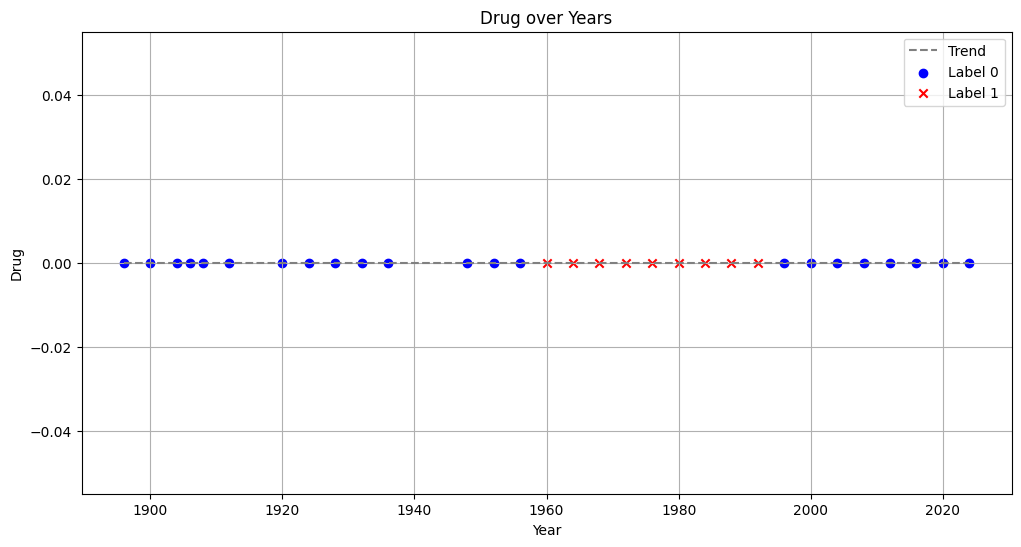

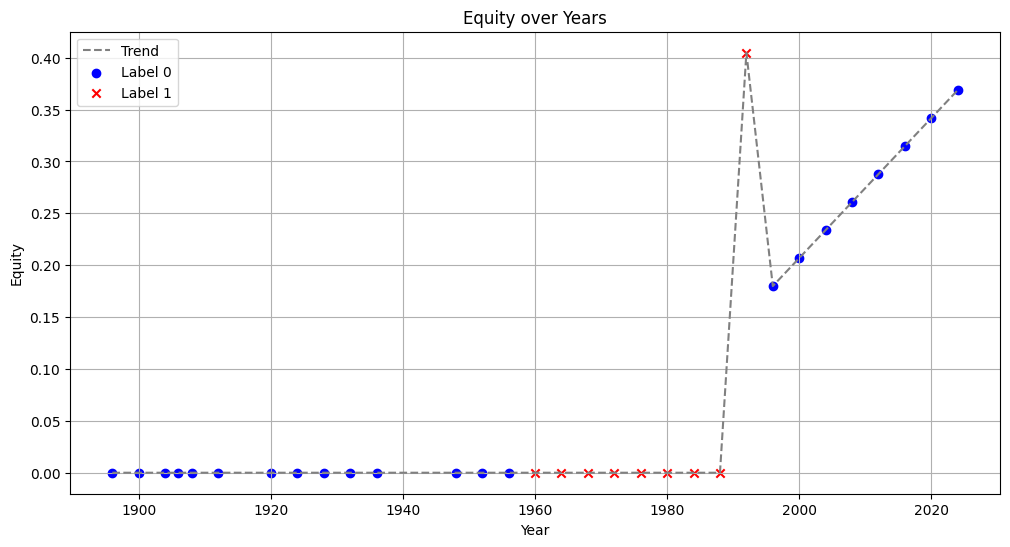

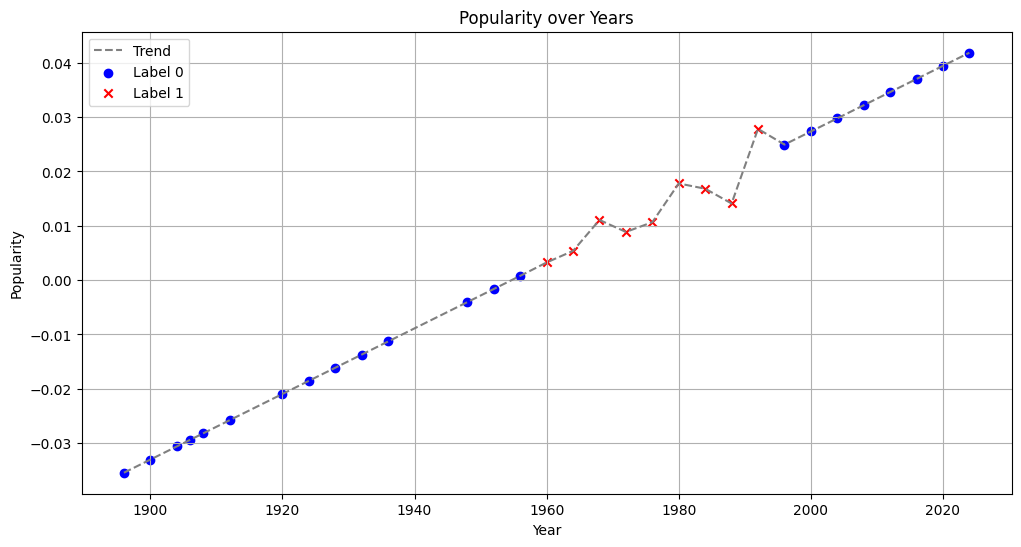

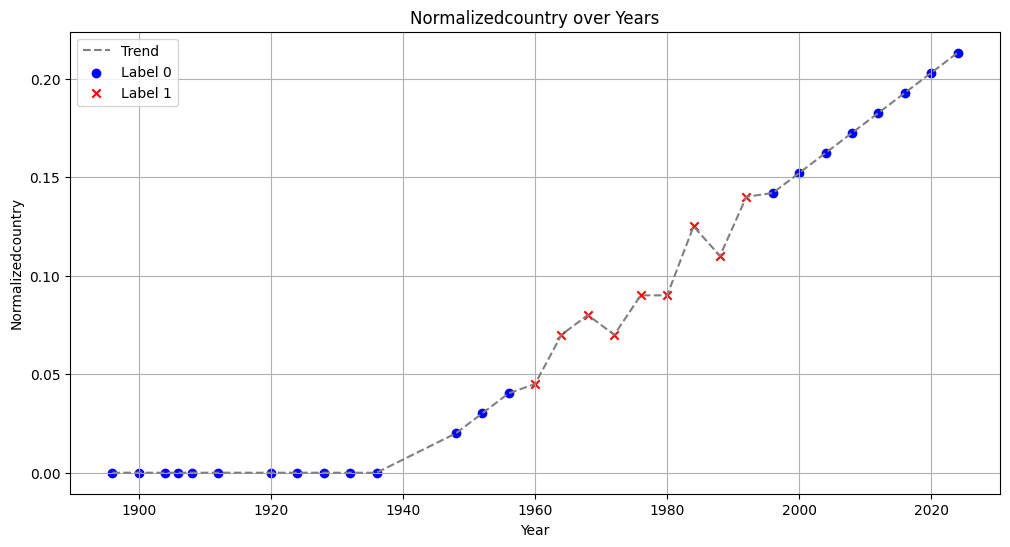

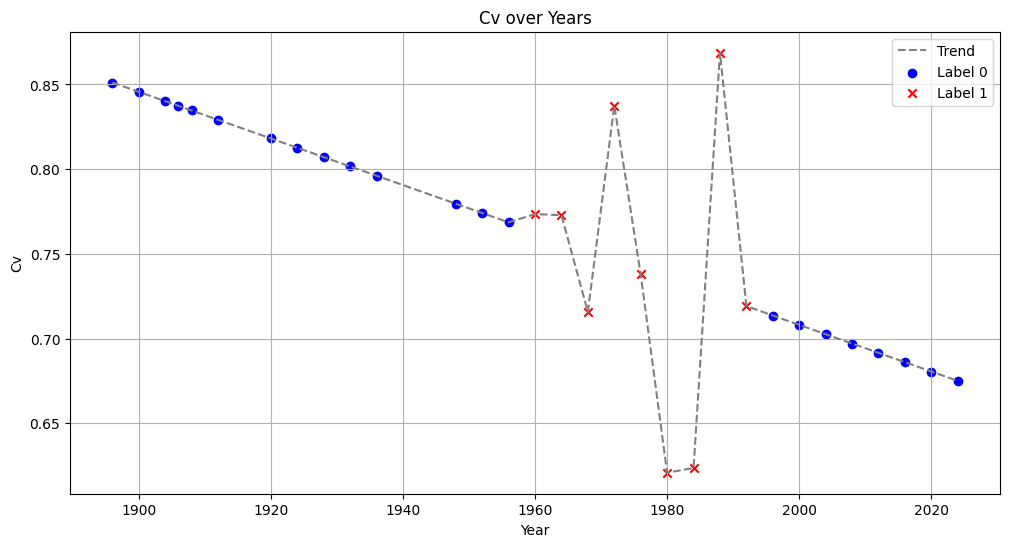

In [ ]:
import matplotlib.pyplot as plt

def plot_data_with_labels(data):
    """
    Plot data with distinct colors for points where label is 1 or 0.

    Parameters:
    data (pd.DataFrame): DataFrame containing the columns: 'drug', 'equity', 'popularity', 
                         'normalizedcountry', 'CV', 'label' with 'Year' as the index.
    """
    # Filter data based on labels
    label_0 = data[data['label'] == 0]
    label_1 = data[data['label'] == 1]

    # Plot each parameter
    parameters = ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV']
    for param in parameters:
        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data[param], color='gray', label='Trend', linestyle='--')
        
        # Scatter plot for label 0
        plt.scatter(label_0.index, label_0[param], color='blue', label='Label 0', marker='o')
        
        # Scatter plot for label 1
        plt.scatter(label_1.index, label_1[param], color='red', label='Label 1', marker='x')
        
        # Add labels and title
        plt.title(f"{param.capitalize()} over Years")
        plt.xlabel("Year")
        plt.ylabel(param.capitalize())
        plt.legend()
        plt.grid(True)
        
        # Save or show the plot
        plt.show()

# Assuming data is in a pandas DataFrame named df
# plot_data_with_labels(df)
plot_data_with_labels(sport_data_dict['Biathlon'])

# preparation for classification model

In [6]:
import pandas as pd

# Initialize an empty list to store each sport's data
all_sports_data = []

# Iterate over the sport_data_dict to process each sport's DataFrame
for sport, df in sport_data_dict.items():
    df = df.reset_index()  # Ensure 'Year' is a column, not an index
    df['Sport'] = sport  # Add a new column to indicate the sport name
    all_sports_data.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
combined_sport_data = pd.concat(all_sports_data, ignore_index=True)

# Display the first few rows of the combined DataFrame
combined_sport_data


,Year,drug,equity,popularity,normalizedcountry,CV,label,Sport
0,1896,0.0,0.316822,0.029387,0.023511,0.775016,0,Alpine Skiing
1,1900,0.0,0.318375,0.029939,0.031223,0.780618,0,Alpine Skiing
2,1904,0.0,0.319929,0.030490,0.038936,0.786221,0,Alpine Skiing
3,1906,0.0,0.320706,0.030766,0.042793,0.789022,0,Alpine Skiing
4,1908,0.0,0.321482,0.031042,0.046649,0.791823,0,Alpine Skiing
...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,1,Wrestling
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,1,Wrestling
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,1,Wrestling
2013,2020,0.0,0.333333,0.027252,0.356916,0.663988,1,Wrestling


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data
df = pd.read_csv('not_final3.csv')

# Select specific columns by their names
selected_columns = df[['Sport_-1', 'estimate per event_2024']]
selected_columns = selected_columns.drop([65, 66, 67])
selected_columns = selected_columns.rename(columns={'estimate per event_2024': 'sustain', 'Sport_-1': 'Sport'})

# Apply log scale normalization to the sustain column
selected_columns['sustain'] = np.log1p(selected_columns['sustain'])

# Apply Min-Max normalization
scaler = MinMaxScaler()
selected_columns['sustain'] = scaler.fit_transform(selected_columns[['sustain']])

# Display the normalized data
print(selected_columns)


               Sport   sustain
0      Alpine Skiing  0.567916
1           Alpinism  0.464455
2            Archery  0.344805
3   Art Competitions  0.000000
4          Athletics  0.666640
..               ...       ...
60        Tug-Of-War  0.323558
61        Volleyball  0.484022
62        Water Polo  0.526599
63     Weightlifting  0.426390
64         Wrestling  0.437871

[65 rows x 2 columns]


In [8]:
# Merge the DataFrames on the 'Sport' column
merged_df = combined_sport_data.merge(selected_columns, on='Sport', how='left')

# Display the resulting DataFrame
merged_df

,Year,drug,equity,popularity,normalizedcountry,CV,label,Sport,sustain
0,1896,0.0,0.316822,0.029387,0.023511,0.775016,0,Alpine Skiing,0.567916
1,1900,0.0,0.318375,0.029939,0.031223,0.780618,0,Alpine Skiing,0.567916
2,1904,0.0,0.319929,0.030490,0.038936,0.786221,0,Alpine Skiing,0.567916
3,1906,0.0,0.320706,0.030766,0.042793,0.789022,0,Alpine Skiing,0.567916
4,1908,0.0,0.321482,0.031042,0.046649,0.791823,0,Alpine Skiing,0.567916
...,...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,1,Wrestling,0.437871
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,1,Wrestling,0.437871
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,1,Wrestling,0.437871
2013,2020,0.0,0.333333,0.027252,0.356916,0.663988,1,Wrestling,0.437871


# EDA

drug                 0
equity               0
popularity           0
normalizedcountry    0
CV                   0
label                0
dtype: int64


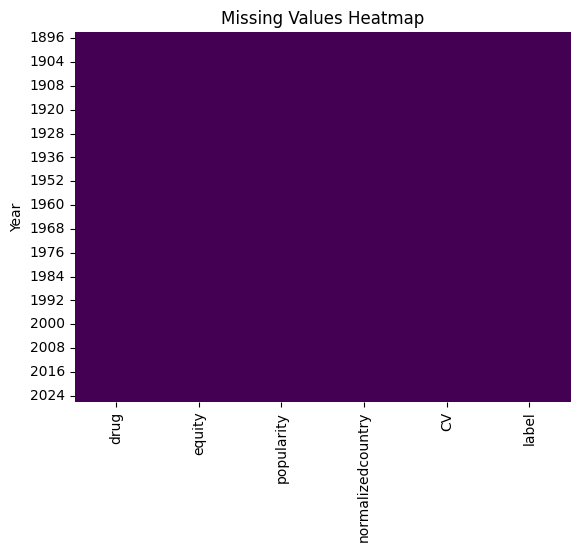

In [9]:

import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load your data
# Assuming 'merged_df' is your combined dataset.
cleaned_data = merged_df.drop(['Sport'], axis=1).dropna()  # Exclude 'Sport' column

# Separate features and labels
X = cleaned_data.drop(['label'], axis=1)  # Features
y = cleaned_data['label']  # Labels
# Check for missing values
print(data.isnull().sum())

# Visualize missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()



/tmp/ipykernel_130160/3573094281.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


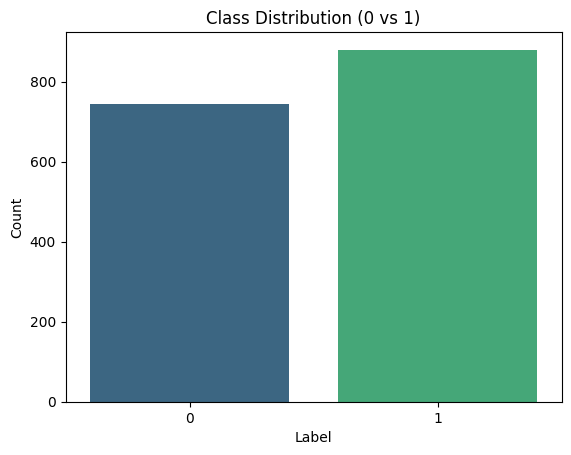

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize class distribution
sns.countplot(x=y, palette='viridis')
plt.title('Class Distribution (0 vs 1)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


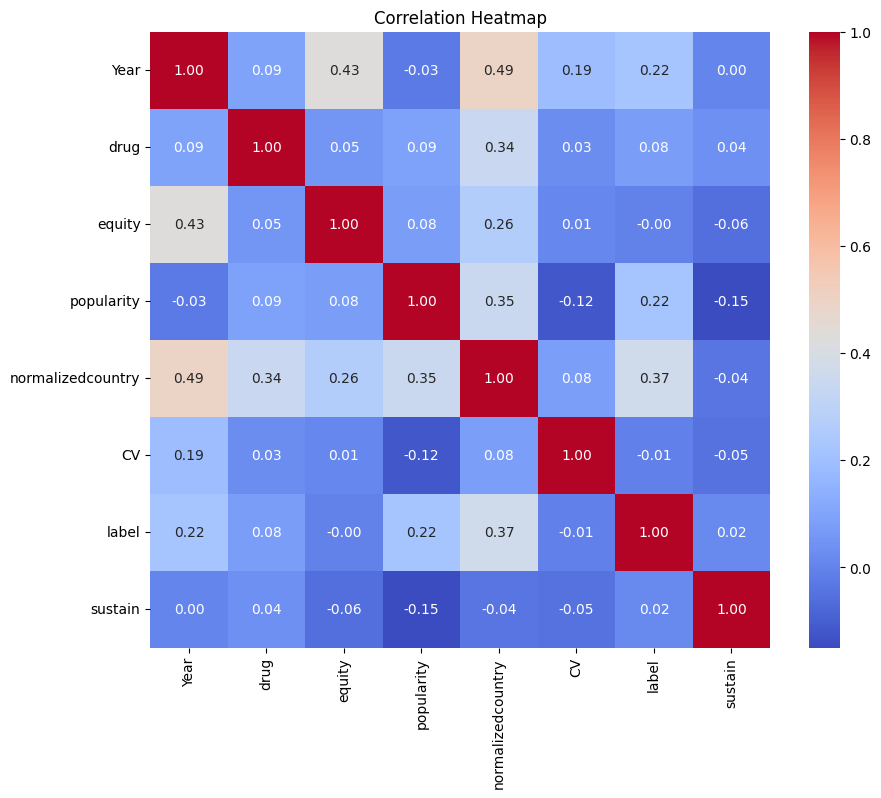

In [11]:
# Compute correlation matrix
correlation_matrix = cleaned_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


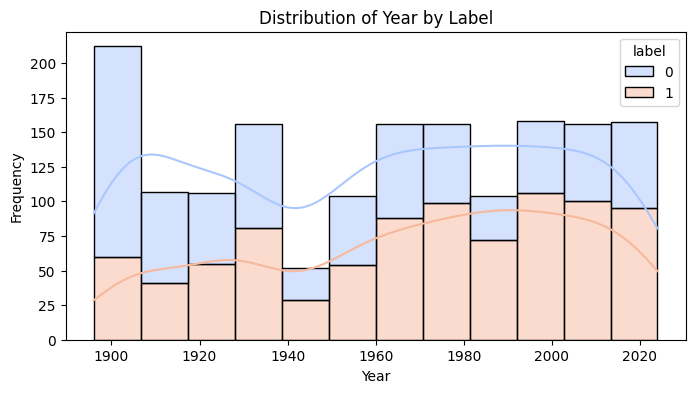

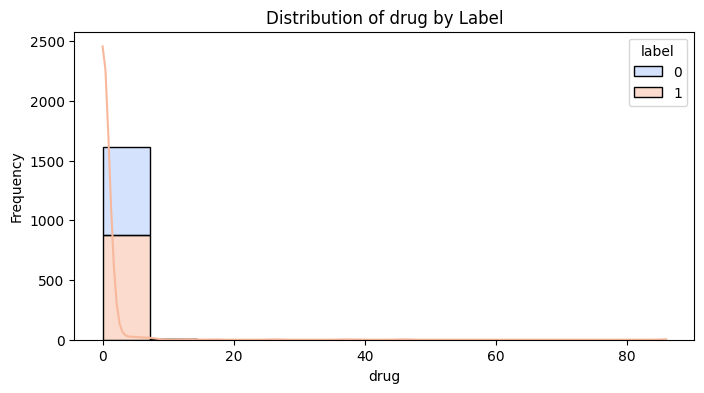

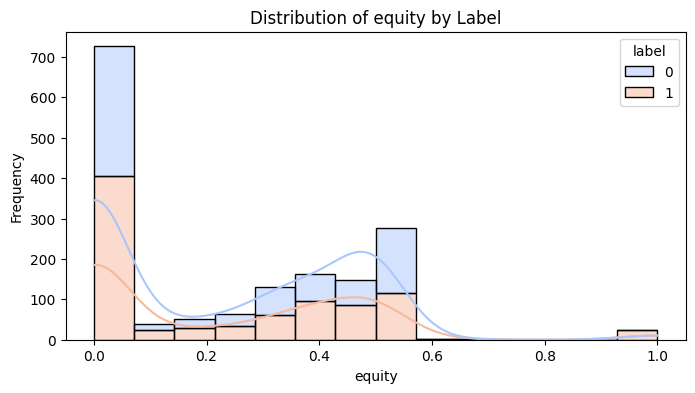

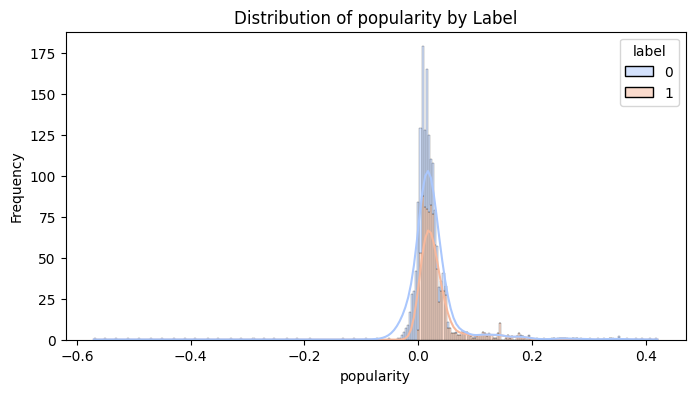

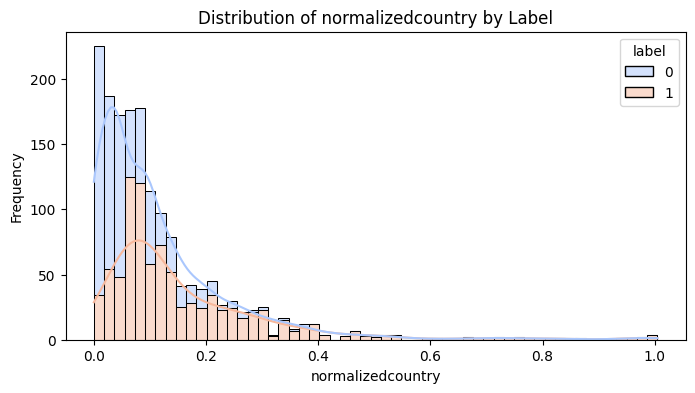

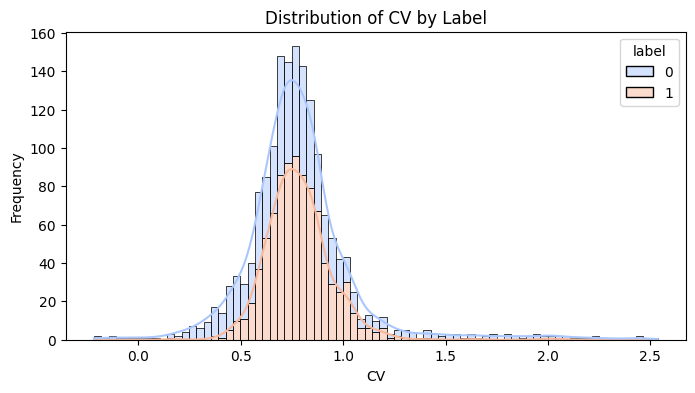

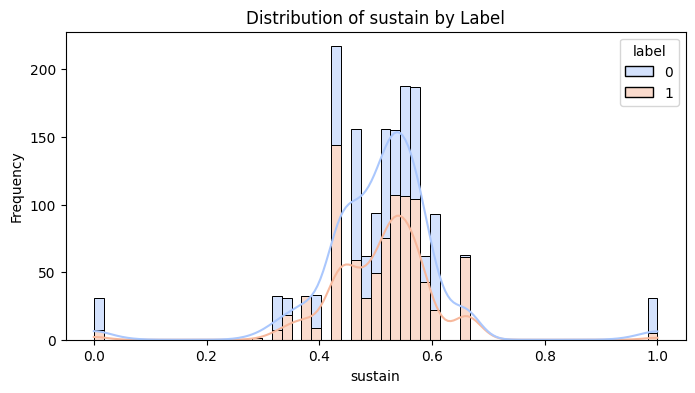

In [12]:
# Visualize distributions of each feature based on label
for col in X.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(cleaned_data, x=col, hue='label', multiple='stack', kde=True, palette='coolwarm')
    plt.title(f'Distribution of {col} by Label')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


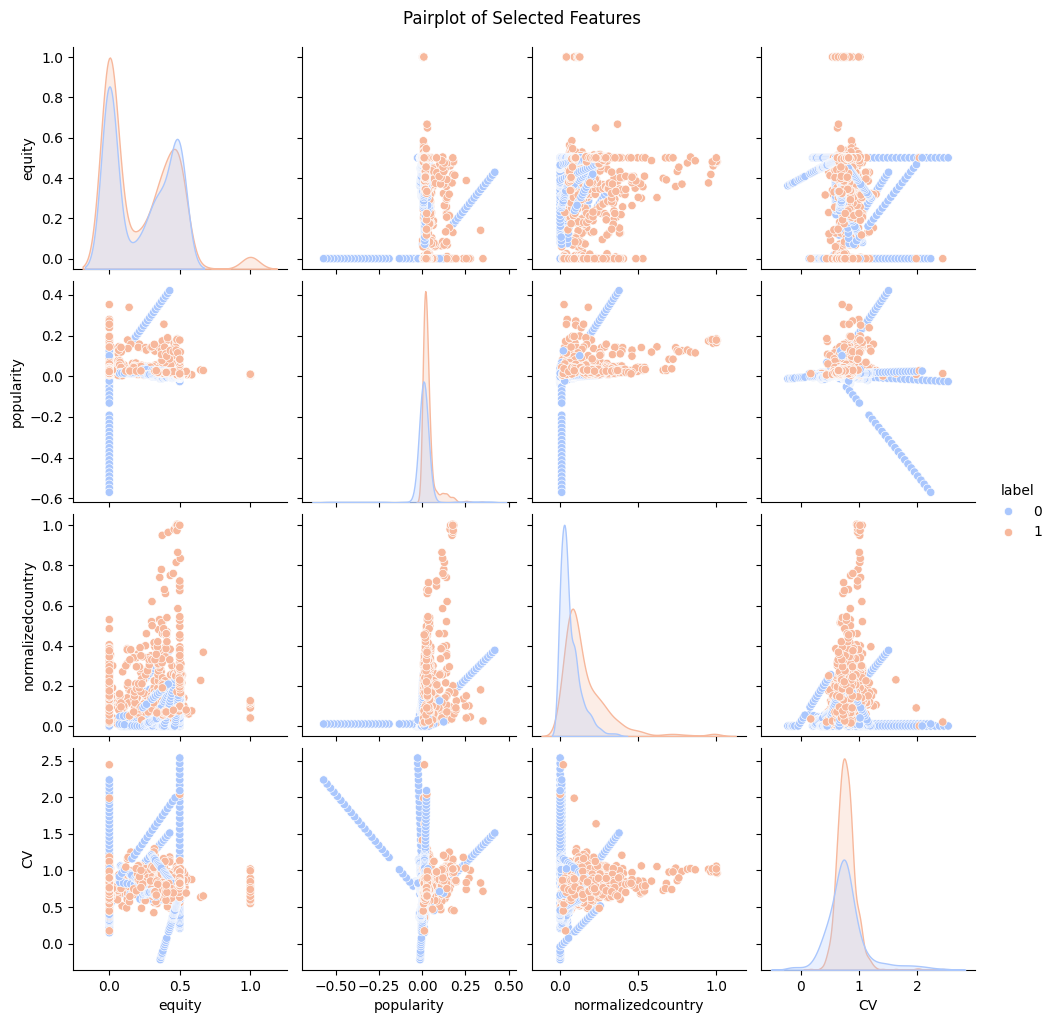

In [13]:
# Visualize pairwise relationships
sns.pairplot(cleaned_data, vars=['equity', 'popularity', 'normalizedcountry', 'CV'], hue='label', palette='coolwarm')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()


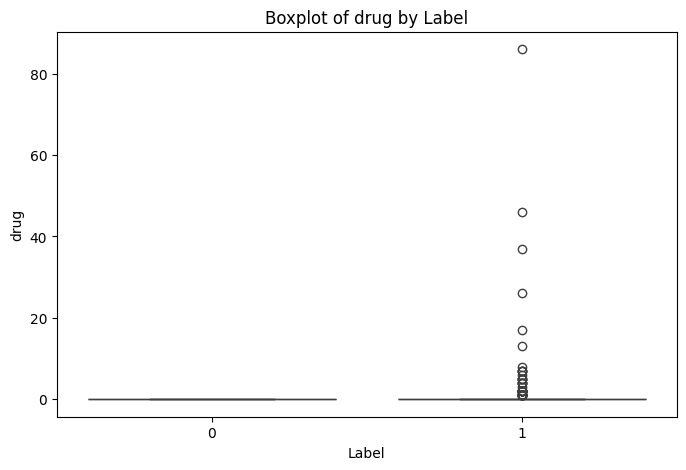

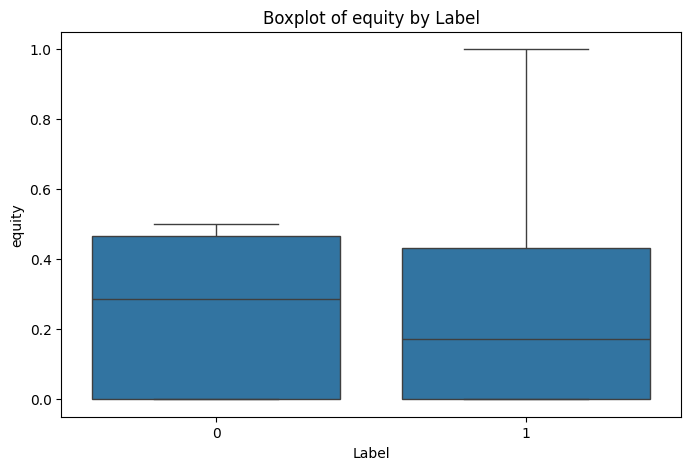

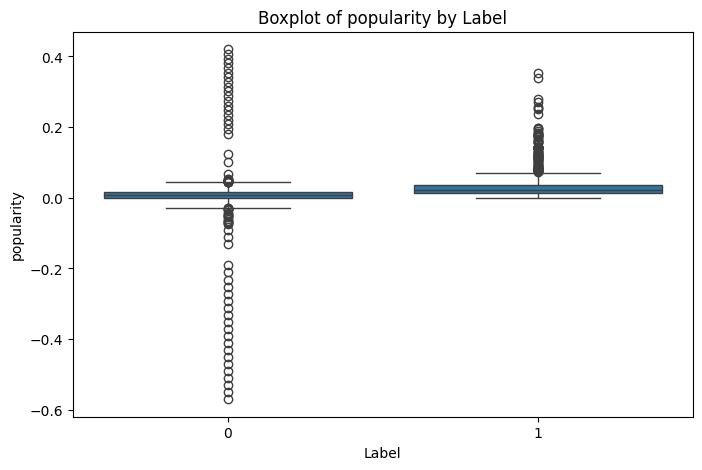

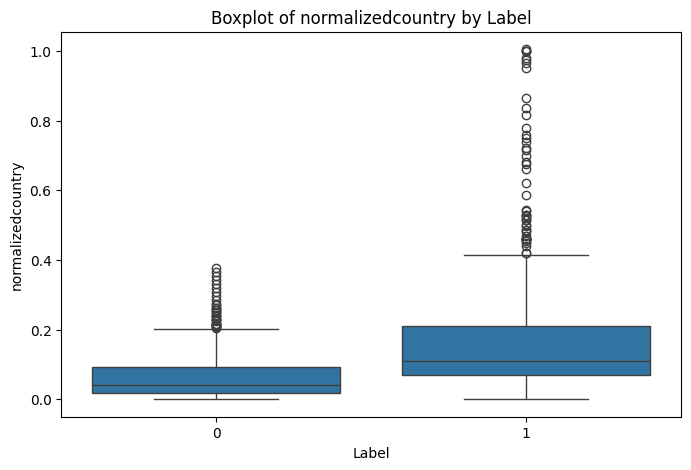

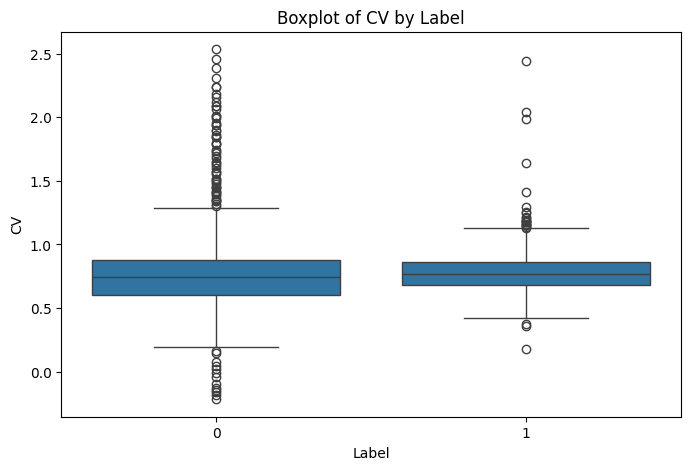

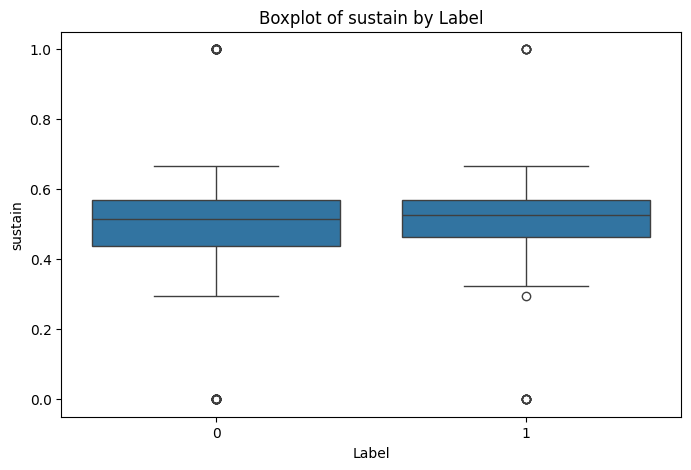

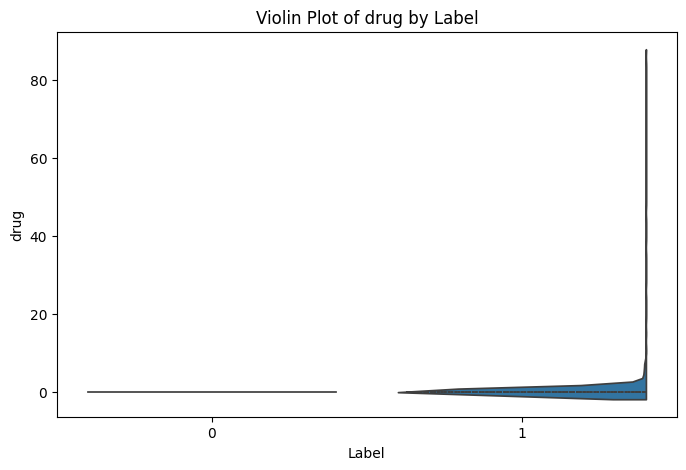

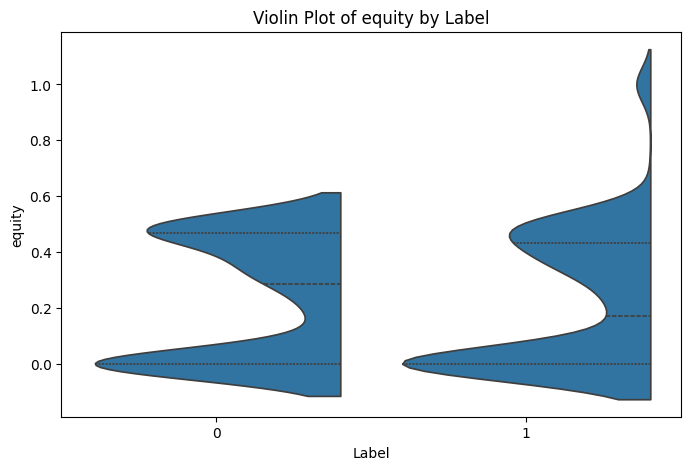

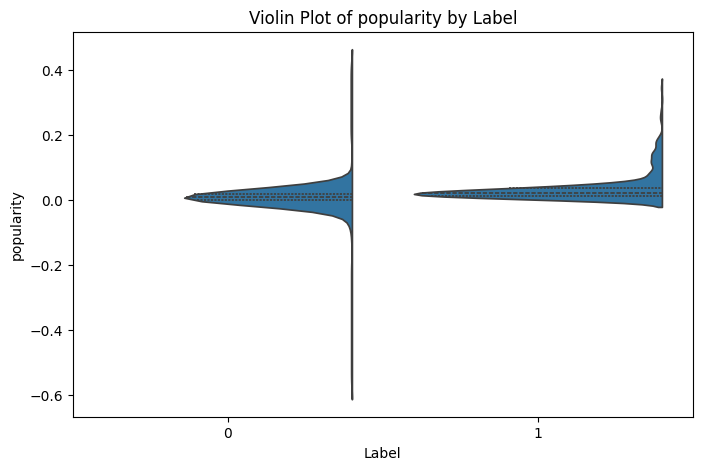

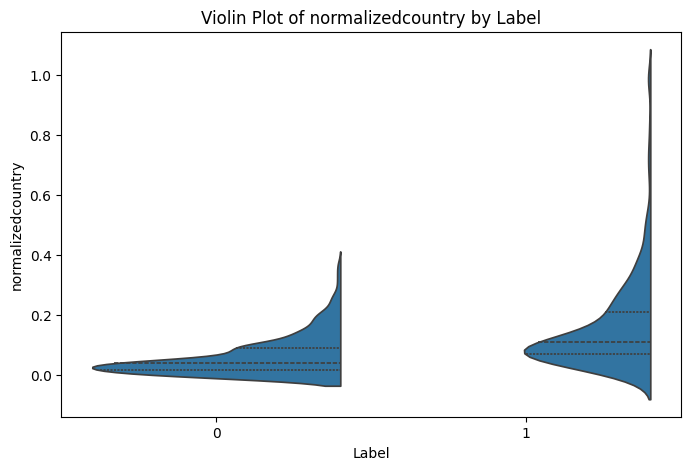

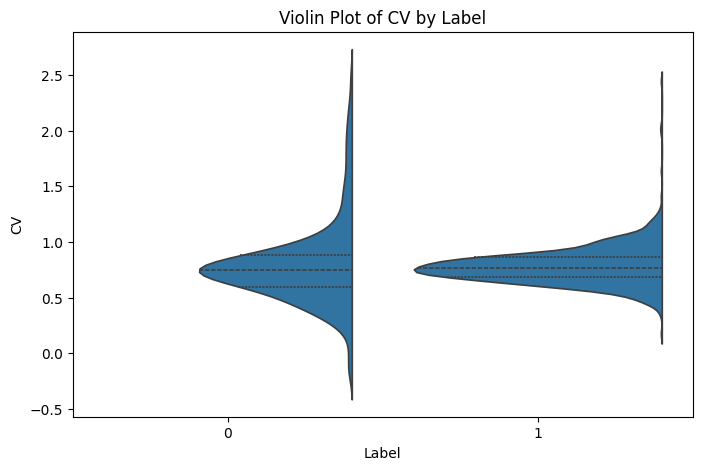

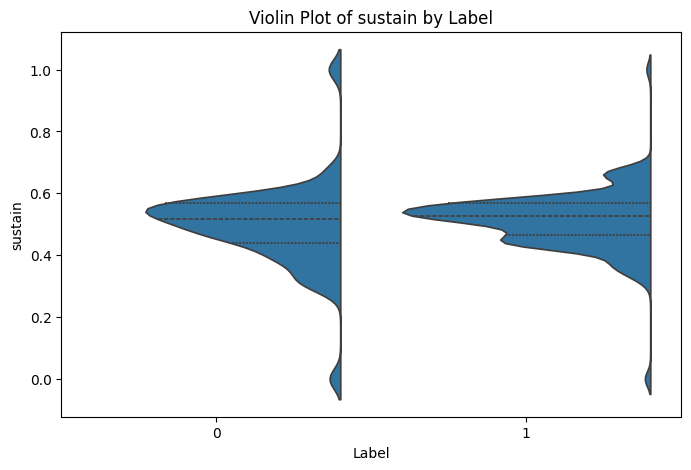

In [14]:


# 4. Boxplot of each feature grouped by label
for col in ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'sustain']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='label', y=col, data=merged_df)
    plt.title(f'Boxplot of {col} by Label')
    plt.xlabel('Label')
    plt.ylabel(col)
    plt.show()

# 5. Violin plot to observe the distribution
for col in ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'sustain']:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='label', y=col, data=merged_df, split=True, inner='quartile')
    plt.title(f'Violin Plot of {col} by Label')
    plt.xlabel('Label')
    plt.ylabel(col)
    plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Assuming X and y are ready after EDA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Helper function to train and evaluate
def train_evaluate_model(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred, output_dict=True)


In [16]:
print("Training on imbalanced data...")
baseline_results = train_evaluate_model(X_train, y_train, X_test, y_test)
print("Training with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
smote_results = train_evaluate_model(X_train_smote, y_train_smote, X_test, y_test)
print("Training with Downsampling...")
undersampler = RandomUnderSampler(random_state=42)
X_train_downsample, y_train_downsample = undersampler.fit_resample(X_train, y_train)
downsample_results = train_evaluate_model(X_train_downsample, y_train_downsample, X_test, y_test)


Training on imbalanced data...
Training with SMOTE...
Training with Downsampling...


              precision    recall  f1-score  support
Baseline       0.707021  0.707692  0.707026    325.0
SMOTE          0.669247  0.661538  0.661769    325.0
Downsampling   0.672839  0.664615  0.664774    325.0


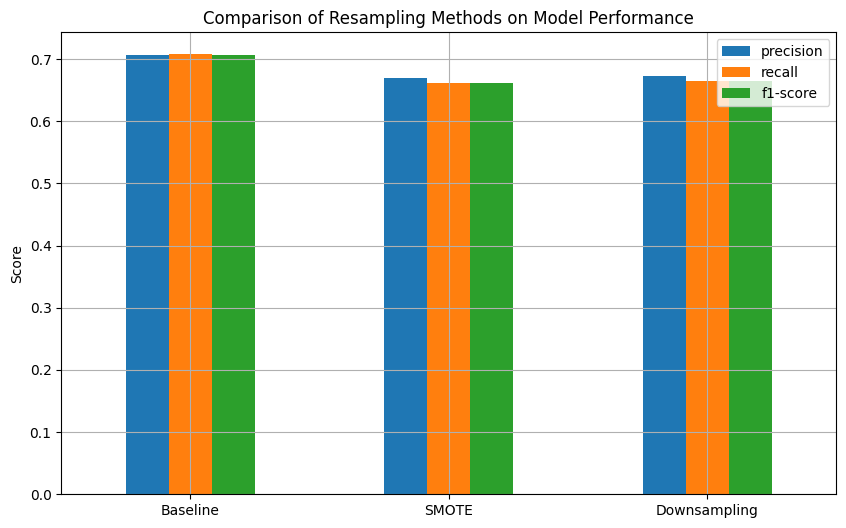

In [17]:


results = {
    "Baseline": baseline_results["weighted avg"],
    "SMOTE": smote_results["weighted avg"],
    "Downsampling": downsample_results["weighted avg"]
}

results_df = pd.DataFrame(results).T
print(results_df)

# Plot comparison
results_df[["precision", "recall", "f1-score"]].plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Resampling Methods on Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline

# Create directories for results
os.makedirs("class_results", exist_ok=True)
os.makedirs("class_weights", exist_ok=True)
os.makedirs("class_plots", exist_ok=True)

# Define data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, RocCurveDisplay

def train_and_evaluate_model(model, model_name, param_grid=None):
    """
    Train and evaluate a given model.
    If param_grid is provided, use GridSearchCV for hyperparameter tuning.
    """
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        best_model = model.fit(X_train, y_train)
        best_params = None
    
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Model: {model_name}\nAccuracy: {acc}")
    
    # Save weights and results
    model_path = f"class_weights/{model_name}_model.pkl"
    pd.to_pickle(best_model, model_path)
    
    # Save results
    with open(f"class_results/{model_name}_report.txt", 'w') as f:
        f.write(classification_report(y_test, y_pred))
        f.write(f"\nBest Params: {best_params}")
    
    # Plot and save ROC curve
    RocCurveDisplay.from_estimator(best_model, X_test, y_test)
    plt.savefig(f"class_plots/{model_name}_roc_curve.png")
    plt.close()

    # Plot and save confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"class_plots/{model_name}_confusion_matrix.png")
    plt.close()
    
    return best_model


In [28]:
from sklearn.linear_model import LogisticRegression

logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

train_and_evaluate_model(LogisticRegression(), "LogisticRegression", logreg_params)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.0s[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.0s

[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.0s

[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l2, s

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

LogisticRegression(C=1)

In [34]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

class ClassificationPipeline:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.models = self._initialize_models()
        self.results_dir = "class_results"
        self.weights_dir = "class_weights"
        self.plots_dir = "class_plots"
        self._prepare_directories()
    
    def _initialize_models(self):
        """Initialize models with hyperparameter grids for tuning."""
        return {
            "LogisticRegression": {
                "model": LogisticRegression(max_iter=500),
                "params": {"C": [0.01, 0.1, 1, 10]}
            },
            "DecisionTree": {
                "model": DecisionTreeClassifier(),
                "params": {"max_depth": [3, 5, 10, None]}
            },
            "RandomForest": {
                "model": RandomForestClassifier(),
                "params": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None]}
            },
            "GradientBoosting": {
                "model": GradientBoostingClassifier(),
                "params": {"learning_rate": [0.01, 0.1, 0.2], "n_estimators": [50, 100]}
            },
            "AdaBoost": {
                "model": AdaBoostClassifier(),
                "params": {"n_estimators": [50, 100]}
            },
            "Bagging": {
                "model": BaggingClassifier(),
                "params": {"n_estimators": [10, 50, 100]}
            },
            "SVM": {
                "model": SVC(probability=True),
                "params": {"C": [0.1, 1], "kernel": ["rbf"]}
            },
            "MLP": {
                "model": MLPClassifier(max_iter=1000),
                "params": {"hidden_layer_sizes": [(50,), (100,), (50, 50)]}
            },
            "KNN": {
                "model": KNeighborsClassifier(),
                "params": {"n_neighbors": [3, 5, 7]}
            },
            "GaussianNB": {
                "model": GaussianNB(),
                "params": None  # No hyperparameters for Naive Bayes
            },
            "LDA": {
                "model": LinearDiscriminantAnalysis(),
                "params": None  # No hyperparameters for LDA
            }
        }
    
    def _prepare_directories(self):
        """Create directories for saving results, weights, and plots."""
        os.makedirs(self.results_dir, exist_ok=True)
        os.makedirs(self.weights_dir, exist_ok=True)
        os.makedirs(self.plots_dir, exist_ok=True)
    
    def train_and_evaluate_model(self, model_name, model, param_grid=None):
        """Train and evaluate a single model."""
        if param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)
            grid_search.fit(self.X_train, self.y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = model.fit(self.X_train, self.y_train)
            best_params = None
        
        y_pred = best_model.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred)
        print(f"Model: {model_name}\nAccuracy: {acc}")
        
        # Save model weights
        model_path = os.path.join(self.weights_dir, f"{model_name}_model.pkl")
        pd.to_pickle(best_model, model_path)
        
        # Save classification report
        with open(os.path.join(self.results_dir, f"{model_name}_report.txt"), "w") as f:
            f.write(classification_report(self.y_test, y_pred))
            f.write(f"\nBest Params: {best_params}")
        
        # Plot and save ROC curve
        RocCurveDisplay.from_estimator(best_model, self.X_test, self.y_test)
        plt.savefig(os.path.join(self.plots_dir, f"{model_name}_roc_curve.png"))
        plt.close()

        # Plot and save confusion matrix heatmap
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
        plt.title(f"Confusion Matrix for {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.savefig(os.path.join(self.plots_dir, f"{model_name}_confusion_matrix.png"))
        plt.close()
        
        return best_model, acc
    
    def run(self):
        """Run training and evaluation for all models."""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        results = []
        
        for model_name, config in self.models.items():
            print(f"Training {model_name}...")
            best_model, acc = self.train_and_evaluate_model(model_name, config["model"], config["params"])
            results.append({"Model": model_name, "Accuracy": acc})
        
        # Save summary results
        results_df = pd.DataFrame(results)
        results_df.to_csv(os.path.join(self.results_dir, "model_comparison.csv"), index=False)
        print("All models trained and evaluated.")


In [35]:
pipeline = ClassificationPipeline(X, y)
pipeline.run()


Training LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END ................................................C=1; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END .............................................C=0.01; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.1s
[CV] END .............................................C=0.01; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ...................

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[CV] END ................................................C=1; total time=   0.0s
Model: LogisticRegression
Accuracy: 0.6987704918032787
Training DecisionTree...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................ma

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

[CV] END ....................................n_estimators=50; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=100; total time=   0.4s


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoost
Accuracy: 0.8340163934426229
Training Bagging...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.3s
[CV] END ....................................n_estimators=50; total time=   0.3s
[CV] END ....................................n_estimators=50; total time=   0.3s
[CV] END ....................................n_estimators=50; total time=   0.4s
[CV] END ....................................n_estimators=50; total time=   0.4s
[CV] END ...................................n_estimators=100; tot

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Training MLP...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..........................hidden_layer_sizes=(100,); total time=   0.1s
[CV] END ........................hidden_layer_sizes=(50, 50); total time=   0.1s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   0.2s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   0.2s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   0.2s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   0.2s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   0.2s
[CV] END ........................hidden_layer_sizes=(50, 50); total time=   0.2s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   0.2s
[CV] END ..........................hidden_layer_sizes=(100,); total time=   0.3s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   0.3s
[CV] END ........................

/tmp/ipykernel_116062/2559207714.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


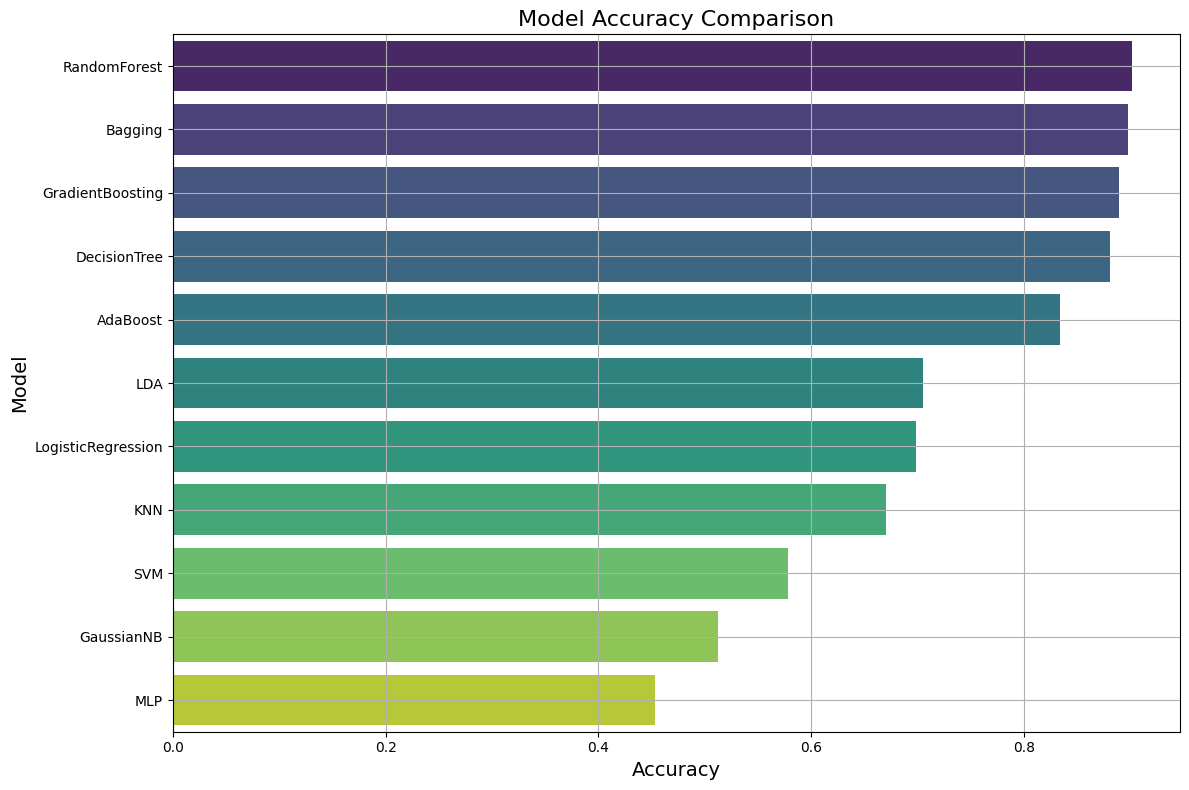

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the accuracy scores saved in a CSV
results_df = pd.read_csv('class_results/model_comparison.csv')

# Sort models by accuracy for better visualization
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Plot the accuracy scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('class_plots/model_accuracy_comparison.png')
plt.show()


# Advanced model

In [14]:
import tensorflow as tf
# Disable GPU programmatically in your Python script
tf.config.set_visible_devices([], 'GPU')

# Verify that only the CPU is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Example model to confirm CPU usage
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Using device:", tf.test.gpu_device_name() or "CPU")
# Check if TensorFlow is built with GPU support
print("Is TensorFlow built with GPU support?", tf.test.is_built_with_cuda())

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {gpus}")
    for gpu in gpus:
        print(f"GPU details: {gpu}")
else:
    print("No GPUs available.")


2024-11-17 19:52:12.512589: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 19:52:12.522066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731847932.533563  130160 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731847932.537008  130160 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 19:52:12.549408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1
Using device: /device:GPU:0
Is TensorFlow built with GPU support? True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731847935.804209  130160 gpu_device.cc:2022] Created device /device:GPU:0 with 6299 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [21]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout
import joblib


class AdvancedModelsPipeline:
    def __init__(self, X, y):
        self.X = self._remove_highly_correlated_features(X)
        self.y = y
        self.results = []
        os.makedirs("advanced_model_weights", exist_ok=True)
        os.makedirs("advanced_model_plots", exist_ok=True)
        os.makedirs("advanced_model_results", exist_ok=True)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, y, test_size=0.2, random_state=42)
        
        # Reshape for deep learning models
        self.X_train_dl = self.X_train.values.reshape(-1, self.X_train.shape[1], 1)
        self.X_test_dl = self.X_test.values.reshape(-1, self.X_test.shape[1], 1)

    def _remove_highly_correlated_features(self, X, threshold=0.95):
        """Remove features with correlation above the threshold."""
        corr_matrix = X.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
        print(f"Removing highly correlated features: {to_drop}")
        return X.drop(columns=to_drop)

    def train_and_evaluate(self, model, model_name):
        """Train and evaluate a given model."""
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred)
        report = classification_report(self.y_test, y_pred)
        
        # Save weights
        model_path = f"advanced_model_weights/{model_name}_model.pkl"
        joblib.dump(model, model_path)

        # Save classification report
        report_path = f"advanced_model_results/{model_name}_report.txt"
        with open(report_path, 'w') as f:
            f.write(report)
        
        # Store results
        self.results.append({'Model': model_name, 'Accuracy': acc})
        
        print(f"Model: {model_name} | Accuracy: {acc}")

        # Plot ROC curve
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(self.X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(self.X_test)
        else:
            print(f"Skipping ROC for {model_name}, no suitable method found.")
            return
        
        if np.any(np.isnan(y_prob)):
            print(f"Skipping {model_name} due to NaN in probabilities.")
            return
        
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
        plt.title(f'{model_name} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.savefig(f"advanced_model_plots/{model_name}_roc_curve.png")
        plt.close()

        # Plot confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
        plt.title(f"Confusion Matrix for {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.savefig(f"advanced_model_plots/{model_name}_confusion_matrix.png")
        plt.close()

    def run(self):
        """Run training and evaluation for all models."""
        self.train_and_evaluate(QuadraticDiscriminantAnalysis(), "QDA")
        self.train_and_evaluate(GaussianNB(), "Naive Bayes")
        
        stack = StackingClassifier(estimators=[
            ('rf', RandomForestClassifier()),
            ('lr', LogisticRegression())])
        self.train_and_evaluate(stack, "Stacking Classifier")

        vote = VotingClassifier(estimators=[
            ('dt', DecisionTreeClassifier()),
            ('svc', SVC(probability=True))])
        self.train_and_evaluate(vote, "Voting Classifier")

        self.train_cnn()
        self.train_rnn(LSTM, "LSTM")
        self.train_rnn(GRU, "GRU")

    def train_cnn(self):
        model = Sequential([
            Conv1D(32, kernel_size=3, activation='relu', input_shape=(self.X_train_dl.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(self.X_train_dl, self.y_train, epochs=10, validation_data=(self.X_test_dl, self.y_test), verbose=0)
        self._save_deep_model_results(model, "CNN", history)

    def train_rnn(self, rnn_layer, model_name):
        model = Sequential([
            rnn_layer(50, return_sequences=False, input_shape=(self.X_train_dl.shape[1], 1)),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(self.X_train_dl, self.y_train, epochs=10, validation_data=(self.X_test_dl, self.y_test), verbose=0)
        self._save_deep_model_results(model, model_name, history)

    def _save_deep_model_results(self, model, model_name, history):
        acc = history.history['val_accuracy'][-1]
        self.results.append({'Model': model_name, 'Accuracy': acc})
        model.save(f'advanced_model_weights/{model_name}_model.h5')

        # Plot learning curve
        plt.figure()
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Learning Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(f"advanced_model_plots/{model_name}_learning_curve.png")
        plt.close()
    def plot_comparison(self):
        """Plot a comparison of model accuracies."""
        results_df = pd.DataFrame(self.results)
        results_df = results_df.sort_values(by='Accuracy', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
        plt.title('Model Accuracy Comparison')
        plt.xlabel('Accuracy')
        plt.ylabel('Model')
        plt.xlim(0, 1)  # Assuming accuracy is between 0 and 1
        plt.savefig("advanced_model_plots/model_comparison.png")
        plt.show()



In [22]:
print(X.isnull().sum())  # Check for NaN in features
print(y.isnull().sum())  # Check for NaN in labels


Year                 0
drug                 0
equity               0
popularity           0
normalizedcountry    0
CV                   0
sustain              0
dtype: int64
0


In [23]:
import tensorflow as tf
print(tf.sysconfig.get_build_info()["cuda_version"])  # TensorFlow's expected CUDA version
print(tf.sysconfig.get_build_info()["cudnn_version"])  # TensorFlow's expected cuDNN version


12.5.1
9


In [24]:
pipeline = AdvancedModelsPipeline(X, y)
pipeline.run()


Removing highly correlated features: []
Model: QDA | Accuracy: 0.44
Skipping QDA due to NaN in probabilities.
Model: Naive Bayes | Accuracy: 0.5292307692307693


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:972: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:972: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:975: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

Model: Stacking Classifier | Accuracy: 0.9230769230769231
Model: Voting Classifier | Accuracy: 0.88
Skipping ROC for Voting Classifier, no suitable method found.


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


/tmp/ipykernel_130160/807214907.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


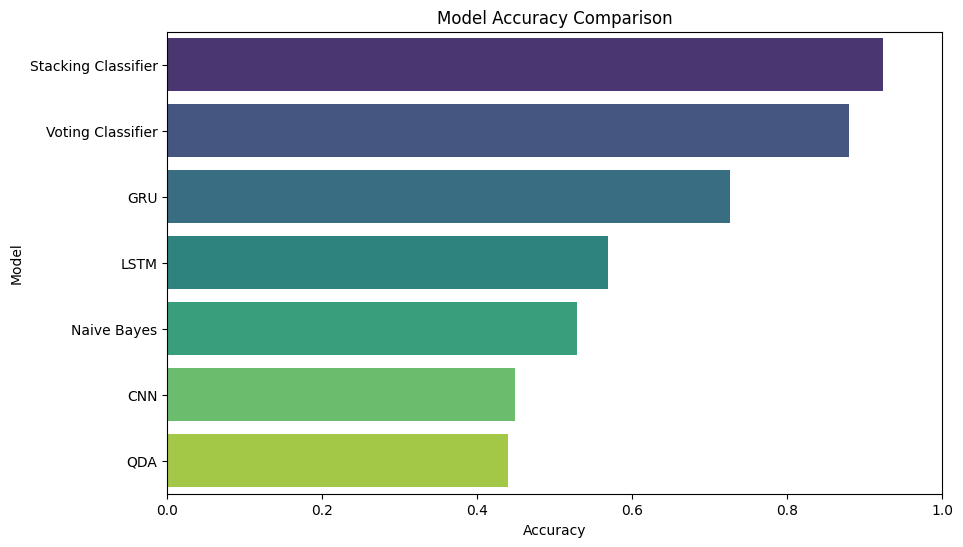

In [25]:
pipeline.plot_comparison()